# Fake News Detection – Complete NLP Notebook

The objective of this project is to build a machine learning model capable of distinguishing real news from fake news using Natural Language Processing (NLP) techniques. Fake news has become a significant issue due to its impact on public opinion, making automatic detection an important task.

This project explores classical NLP approaches combined with supervised machine learning models to address this problem

## Import libraries 

In [206]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


import nltk

nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/helenagomez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/helenagomez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Charge CSV from dataset/



The dataset consists of news articles labeled as real (0) or fake (1).
The training dataset was split into training and testing subsets using an 80/20 ratio, ensuring that class proportions were preserved.

A separate testing dataset without labels was provided to generate final predictions.

In [207]:
import pandas as pd

train_df = pd.read_csv(
    "dataset/training_data.csv",
    sep="\t",
    header=None,
    names=["label", "text"]
)

test_df = pd.read_csv(
    "dataset/testing_data.csv",
    sep="\t",
    header=None,
    names=["label", "text"]
)

train_df.head(1000)



,label,text
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...
...,...,...
995,0,gop rep. wants a $30k a year housing allowance...
996,0,brace yourself for 74 percent higher health ca...
997,0,grandma will have to pay more than $20k a year...
998,0,the absolutely cringeworthy moment trump tried...


# Explore the data 

In [208]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34152 entries, 0 to 34151
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   34152 non-null  int64 
 1   text    34152 non-null  object
dtypes: int64(1), object(1)
memory usage: 533.8+ KB


In [209]:
train_df.head()
train_df["label"].value_counts()


label
0    17572
1    16580
Name: count, dtype: int64

In [210]:
train_df.shape

(34152, 2)

# Data Procesing


Before modeling, text data was preprocessed to reduce noise and standardize the input.
The following steps were applied:

* Conversion to lowercase

* Removal of punctuation and numerical characters

* Tokenization

* Removal of stopwords using NLTK

This preprocessing step ensures that the models focus on meaningful textual patterns rather than irrelevant variations.

In [211]:
def clean_text(text):
    # 1. Pasar a minúsculas
    text = text.lower()
    
    # 2. Eliminar puntuación y números (mantiene acentos)
    text = re.sub(r'[^a-záéíóúñü\s]', '', text)
    
    # 3. Tokenización
    tokens = word_tokenize(text, language='spanish')
    
    # 4. Eliminar stopwords
    tokens = [t for t in tokens if t not in stop_words]
    
    return tokens



In [212]:
texts = train_df["text"]
y = train_df["label"]        

# Dividing Training Dataset into train and test

In [213]:
X_train, X_test, y_train, y_test = train_test_split(
    texts,
    y,
    test_size=0.2,       
    random_state=42,     
    stratify=y          
)


In [214]:
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

print("\nDistribution train:")
print(y_train.value_counts(normalize=True))

print("\nDistribution test:")
print(y_test.value_counts(normalize=True))


Train size: (27321,)
Test size: (6831,)

Distribution train:
label
0    0.514513
1    0.485487
Name: proportion, dtype: float64

Distribution test:
label
0    0.514566
1    0.485434
Name: proportion, dtype: float64


<Axes: xlabel='label'>

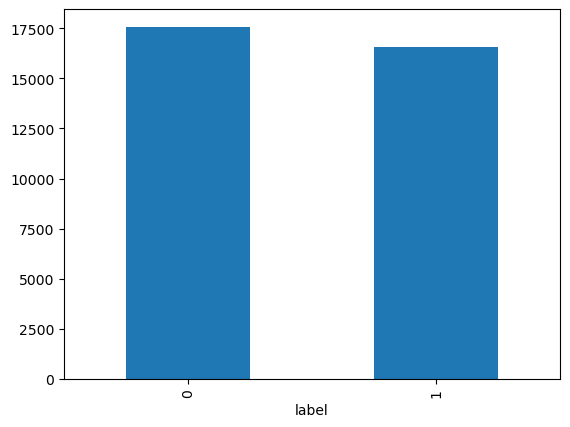

In [246]:
y.value_counts().plot(kind="bar")


# TexT vectorization

Two text representation techniques were explored:
* Bag of Words (BoW)
* TF-IDF (Term Frequency–Inverse Document Frequency)

Different configurations were tested by varying parameters such as:

* n-gram ranges
* minimum and maximum document frequency
* maximum number of features
* custom tokenizer

TF-IDF proved to be more effective, as it reduces the influence of very frequent but less informative words.

# Bag of Words (CountVectorizer)

In [215]:
def vectorize_bow(X_train, X_test):
    vectorizer = CountVectorizer(
        tokenizer=clean_text,
        ngram_range=(1, 2),
        max_df=0.9,
        min_df=3,
        max_features=10000
    )
    return (
        vectorizer.fit_transform(X_train),
        vectorizer.transform(X_test)
    )


# TF-IDF

In [216]:
def vectorize_tfidf(X_train, X_test):
    vectorizer = TfidfVectorizer(
        tokenizer=clean_text,
        ngram_range=(1, 2),
        max_df=0.85,
        min_df=3,
        max_features=15000
    )
    return (
        vectorizer.fit_transform(X_train),
        vectorizer.transform(X_test)
    )



In [217]:
X_train_bow, X_test_bow = vectorize_bow(X_train, X_test)
X_train_tfidf, X_test_tfidf = vectorize_tfidf(X_train, X_test)


/opt/anaconda3/lib/python3.13/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


# Model Training 

Several baseline classifiers were evaluated using both BoW and TF-IDF representations:

* Logistic Regression
* Linear Support Vector Machine (SVM)
* Multinomial Naive Bayes
* Random Forest

Models were compared using accuracy on the test set.

## Define classifiers

In [218]:
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Linear SVM": LinearSVC(),
    "Multinomial NB": MultinomialNB(),
    "Random Forest": RandomForestClassifier(random_state=42)
}


## Trainning and evaluate models


In [219]:
results = []

def evaluate_models(X_train, X_test, representation):
    for name, model in classifiers.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        results.append({
            "Representation": representation,
            "Model": name,
            "Accuracy": acc
        })
        
evaluate_models(X_train_bow, X_test_bow, "BoW")
evaluate_models(X_train_tfidf, X_test_tfidf, "TF-IDF")


In [220]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Accuracy", ascending=False)
results_df


,Representation,Model,Accuracy
5,TF-IDF,Linear SVM,0.944810
0,BoW,Logistic Regression,0.940272
4,TF-IDF,Logistic Regression,0.937637
6,TF-IDF,Multinomial NB,0.936173
2,BoW,Multinomial NB,0.933831
1,BoW,Linear SVM,0.933245
7,TF-IDF,Random Forest,0.915679
3,BoW,Random Forest,0.912312


In [232]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    eval_metric="logloss",
    random_state=42,
    use_label_encoder=False
)

xgb.fit(X_train_tfidf, y_train)

y_pred_xgb = xgb.predict(X_test_tfidf)

xgb_acc = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", xgb_acc)


/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [15:33:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.8872785829307569


#### Model Comparison and Selection

The comparison results showed that TF-IDF combined with Linear SVM achieved the highest accuracy among all baseline models. This model was therefore selected for further optimization.

# Hyperparameter Tuning

Hyperparameter tuning was performed using GridSearchCV on the selected models.
Different values of the regularization parameter C and loss functions were evaluated using 5-fold cross-validation.

This process improved the model’s generalization performance


## Logistic Regression – Hyperparameter Tuning

#### Parámetros a ajustar

* C → regularización

* penalty

* solver

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

lr = LogisticRegression(max_iter=2000)

lr_param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs"]
}

lr_grid = GridSearchCV(
    lr,
    lr_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

lr_grid.fit(X_train_tfidf, y_train)

print("Best LR params:", lr_grid.best_params_)
print("Best LR CV score:", lr_grid.best_score_)

y_pred = lr_grid.best_estimator_.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))



Best LR params: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Best LR CV score: 0.9389478231632417
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3515
           1       0.94      0.95      0.94      3316

    accuracy                           0.95      6831
   macro avg       0.95      0.95      0.95      6831
weighted avg       0.95      0.95      0.95      6831



## Linear SVM – Hyperparameter Tuning

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

svm = LinearSVC()

svm_param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "loss": ["hinge", "squared_hinge"]
}

svm_grid = GridSearchCV(
    svm,
    svm_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

svm_grid.fit(X_train_tfidf, y_train)

print("Best SVM params:", svm_grid.best_params_)
print("Best SVM CV score:", svm_grid.best_score_)

y_pred = svm_grid.best_estimator_.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))


Best SVM params: {'C': 1, 'loss': 'squared_hinge'}
Best SVM CV score: 0.9392406958161816
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      3515
           1       0.94      0.95      0.94      3316

    accuracy                           0.94      6831
   macro avg       0.94      0.94      0.94      6831
weighted avg       0.94      0.94      0.94      6831



Exception ignored in: <function ResourceTracker.__del__ at 0x102935bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x108869bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102455bc0>
Traceback (most recent call last

## Multinomial Naive Bayes – Hyperparameter Tuning

In [230]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

nb = MultinomialNB()

nb_param_grid = {
    "alpha": [0.01, 0.1, 0.5, 1.0]
}

nb_grid = GridSearchCV(
    nb,
    nb_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

# 🔥 AQUÍ ESTABA EL ERROR
nb_grid.fit(X_train_tfidf, y_train)

print("Best NB params:", nb_grid.best_params_)
print("Best NB CV score:", nb_grid.best_score_)

y_pred = nb_grid.best_estimator_.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))




Best NB params: {'alpha': 0.1}
Best NB CV score: 0.9331281856188524
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3515
           1       0.94      0.92      0.93      3316

    accuracy                           0.94      6831
   macro avg       0.94      0.93      0.93      6831
weighted avg       0.94      0.94      0.93      6831



### Final Comparison

In [231]:
print("LR best score:", lr_grid.best_score_)
print("SVM best score:", svm_grid.best_score_)
print("NB best score:", nb_grid.best_score_)


LR best score: 0.9389478231632417
SVM best score: 0.9392406958161816
NB best score: 0.9331281856188524


# Prediction for the Test set

The best-performing model was used to predict the labels for the provided testing dataset.
The placeholder value (2) in the first column was replaced with the predicted class labels (0 or 1), and the updated file was saved for submission

In [240]:
testing_df = pd.read_csv("dataset/testing_data.csv",
    sep="\t",
    header=None,
    names=["label", "text"])

testing_df.head()


,label,text
0,2,copycat muslim terrorist arrested with assault...
1,2,wow! chicago protester caught on camera admits...
2,2,germany's fdp look to fill schaeuble's big shoes
3,2,mi school sends welcome back packet warning ki...
4,2,u.n. seeks 'massive' aid boost amid rohingya '...


In [241]:
testing_texts = testing_df["text"]


In [244]:
best_svm = svm_grid.best_estimator_
X_testing_tfidf = tfidf_vectorizer.transform(testing_texts)
testing_predictions = best_svm.predict(X_testing_tfidf)
testing_df.iloc[:, 0] = testing_predictions
testing_df.head()




,label,text
0,0,copycat muslim terrorist arrested with assault...
1,0,wow! chicago protester caught on camera admits...
2,1,germany's fdp look to fill schaeuble's big shoes
3,0,mi school sends welcome back packet warning ki...
4,1,u.n. seeks 'massive' aid boost amid rohingya '...


In [245]:
testing_df.to_csv("testing_with_predictions.csv", index=False)


This project demonstrates that classical NLP techniques combined with linear classifiers can effectively detect fake news.
Among all evaluated approaches, TF-IDF with a tuned Linear SVM achieved the best overall performance and was selected as the final mode